In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

import gurobipy as gp
from gurobipy import GRB

from itertools import combinations

import time as trun

In [2]:
#instance

#inst_="internet_graph"
#dim_=200
#id_=1
#instance_=f"{inst_}_{dim_}_{id_}"
#G = nx.read_gml(f"../instances/{inst_}/{dim_}/{instance_}.gml.gz",destringizer=int)

inst_="karate"
instance_=f"{inst_}"
G = nx.read_gml(f"../instances/{inst_}/{instance_}.gml.gz",destringizer=int)

In [3]:
nx.is_connected(G)

True

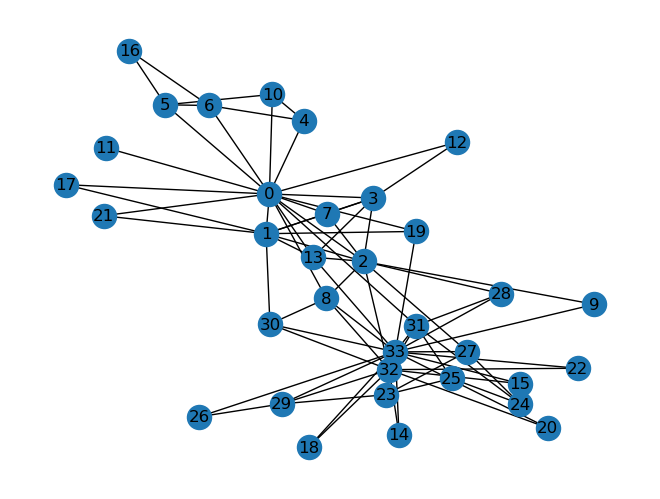

In [4]:
nx.draw(G,  with_labels = True)

In [5]:
def is_subclique(G, nodelist):
    '''
    For each pair of nodes in nodelist whether there is an edge 
    if any edge is missing, we know that it's not a subclique.
    if all edges are there, it is a subclique
    '''
    for (u,v) in combinations(nodelist,2):  #check each possible pair
        if not G.has_edge(u,v):
            return False #if any edge is missing we're done
    return True  #if we get to here, then every edge was there.  It's True.

In [6]:
N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

dm = np.zeros((N,N), dtype=int)

p = nx.shortest_path(G)

for i in range(0,N):
    for j in range(0,N):
        dm[i][j] = len(p[i][j])-1

In [7]:
form_="fmax"
method_="mip"

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=float)
ub = np.zeros((N), dtype=float)
time = np.zeros((N), dtype=float)
gap = np.zeros((N), dtype=float)
nodes = np.zeros((N), dtype=float)
status = np.zeros((N), dtype=float)

con_geo = 0
con_neighb = 1

result_path = Path('../result/')

for i in G:

    Ni = nx.neighbors(G,i)

    listNi = []
    for k in Ni:
        listNi.append(k)

    tstart = trun.time()
    status_clique = is_subclique(G, listNi)
    tend = trun.time()

    elapsed_time = tend - tstart
    
    if(status_clique):
        #print("tukey[%d] = 1" %i)
        lb[i] = 1
        ub[i] = 1
        gap[i] = 0.0
        time[i] = elapsed_time
        nodes[i] = 0
        status[i] = 1
    else:

        model = gp.Model(f"{instance_}")

        # configurando parametros
        #model.Params.TimeLimit = 60
        model.Params.MIPGap = 1.e-6
        model.Params.Threads = 1
        #model.Params.Presolve = 0
        #model.Params.Cuts = 0

        if (method_=="mip"):
            x = model.addVars(N, vtype=GRB.BINARY, name="x")
        else:
            x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")
   
        obj = 0
        for j in G:
            obj += 1 * x[j]
         
        model.setObjective(obj, GRB.MAXIMIZE)
     
        # Turn off display and heuristics
        gp.setParam('OutputFlag', 0)
        gp.setParam('Heuristics', 0)

        model.addConstr(x[i] == 0, "fix_x")

        # geodesic
        if con_geo == 1:
            for u in range(0,N):
                for w in range(u+1,N):
                    #if dm[u,w] <= N:
                        for s in range(0,N):
                            if (s != u) and (s != w):
                                if (dm[u,s] + dm[s,w] == dm[u,w]):
                                    model.addConstr(x[u] + x[w] <= 1 + x[s], "geodesic")
        
        # geodesic neighbors"
        if con_neighb == 1:
            for u in range(0,N):
                Nu = nx.neighbors(G,u)
            
                listNu = []
                for j in Nu:
                    listNu.append(j)

                for w in range(u+1,N):
                    if (w != u) and (w not in listNu):
                        for s in listNu:
                            if (s != w) and (dm[u,s] + dm[s,w] == dm[u,w]):
                                model.addConstr(x[u] + x[w] <= 1 + x[s], "geodesic_neighb")

#       model.write(f"{instance_}.lp")

        model.optimize()

        tmp = 0
        if model.status == GRB.OPTIMAL:
            tmp = 1

        if (method_=="mip"):
            lb[i] = N - model.objBound
            ub[i] = N - model.objVal
            gap[i] = model.MIPGap
            time[i] = model.Runtime
            nodes[i] = model.NodeCount
            status[i] = tmp
        else:
            ub[i] = N - model.objVal
            time[i] = model.Runtime
            status[i] = tmp
        
        model.dispose()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-15
Set parameter MIPGap to value 1e-06
Set parameter Threads to value 1


In [8]:
tksum = np.sum(ub)
tkmax = np.max(ub)
tktime = np.sum(time)

In [9]:
if method_ == "lp":
    for i in G:
        print(
            "node:%d, ub: %2f, time: %2f " % (i, ub[i], time[i])
            )
    
    print("tksum : %.2f" %(tksum))
    print("tkmax : %.2f" %(tkmax))
    print("tktime : %.2f" %(tktime))
    
if method_ == "mip":
    for i in G:
        print(
            "node:%d, lb: %d, ub: %d, gap: %.2f, time: %.2f, nodes: %d, status: %d " 
            % (i, lb[i], ub[i], gap[i], time[i], nodes[i], status[i])
            )
    
    print("tksum : %.2f" %(tksum))
    print("tkmax : %.2f" %(tkmax))
    print("tktime : %.2f" %(tktime))

G.clear()

node:0, lb: 21, ub: 21, gap: 0.00, time: 0.02, nodes: 1, status: 1 
node:1, lb: 21, ub: 21, gap: 0.00, time: 0.08, nodes: 5, status: 1 
node:2, lb: 19, ub: 19, gap: 0.00, time: 0.02, nodes: 1, status: 1 
node:3, lb: 3, ub: 3, gap: 0.00, time: 0.00, nodes: 1, status: 1 
node:4, lb: 2, ub: 2, gap: 0.00, time: 0.00, nodes: 1, status: 1 
node:5, lb: 3, ub: 3, gap: 0.00, time: 0.00, nodes: 1, status: 1 
node:6, lb: 3, ub: 3, gap: 0.00, time: 0.00, nodes: 1, status: 1 
node:7, lb: 1, ub: 1, gap: 0.00, time: 0.00, nodes: 0, status: 1 
node:8, lb: 19, ub: 19, gap: 0.00, time: 0.07, nodes: 4, status: 1 
node:9, lb: 19, ub: 19, gap: 0.00, time: 0.09, nodes: 7, status: 1 
node:10, lb: 2, ub: 2, gap: 0.00, time: 0.00, nodes: 1, status: 1 
node:11, lb: 1, ub: 1, gap: 0.00, time: 0.00, nodes: 0, status: 1 
node:12, lb: 1, ub: 1, gap: 0.00, time: 0.00, nodes: 0, status: 1 
node:13, lb: 19, ub: 19, gap: 0.00, time: 0.05, nodes: 5, status: 1 
node:14, lb: 1, ub: 1, gap: 0.00, time: 0.00, nodes: 0, stat